# Setup

In [ ]:
%%capture
!pip show transformers
!pip show accelerate
!pip install transformers[torch] -U
!pip install accelerate -U
!pip install transformers
!pip install pytorch-lightning
!pip install --upgrade transformers
!pip install datasets

In [ ]:
!pip uninstall transformers
!pip install transformers

Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.37.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? Y
  Successfully uninstalled transformers-4.37.2
  Using cached transformers-4.37.2-py3-none-any.whl (8.4 MB)


# Preprocessing

In [61]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it


# Train Data - 52662 rows after pre-processing (done above)
toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_train_df = toxicity_train_df.dropna()


# Test Data - 7287 rows after pre-processing
toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_test_df = toxicity_test_df.dropna()


# Sampling for CPU use
# fraction = 0.1

# toxicity_train_df = toxicity_train_df.sample(frac=fraction, random_state=42)
# toxicity_test_df = toxicity_test_df.sample(frac=fraction, random_state=42)

# # Reset index for consistency
# toxicity_train_df.reset_index(drop=True, inplace=True)
# toxicity_test_df.reset_index(drop=True, inplace=True)

# List of categories to check
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

# Check if any category is above the 0.5 threshold
toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# Check if any category is above the 0.5 threshold
toxicity_train_df['toxic'] = (toxicity_train_df[categories_to_check] >= 0.25).any(axis=1).astype(float)
toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.25).any(axis=1).astype(float)

# Convert boolean values to 1.0 for True and 0.0 for False
toxicity_train_df['toxic'] = toxicity_train_df['toxic'].astype(float)
toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)

toxicity_train_df = toxicity_train_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]
toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]

print("\nClass distribution in training data before undersampling:")
print(toxicity_train_df['toxic'].value_counts())

print("\nClass distribution in test data before undersampling:")
print(toxicity_test_df['toxic'].value_counts())


# Fraction of the majority class you want to keep (e.g., 0.2 for 20%)
undersample_fraction = 0.5

# Separate the majority and minority classes in training data
majority_class_train = toxicity_train_df[toxicity_train_df['toxic'] == 0]
minority_class_train = toxicity_train_df[toxicity_train_df['toxic'] == 1]

# Undersample the majority class in training data
undersampled_majority_class_train = majority_class_train.sample(frac=undersample_fraction, random_state=42)

# Concatenate the undersampled majority class with the minority class in training data
undersampled_train_df = pd.concat([undersampled_majority_class_train, minority_class_train])

# Shuffle the undersampled training dataframe
toxicity_train_df = undersampled_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate the majority and minority classes in test data
majority_class_test = toxicity_test_df[toxicity_test_df['toxic'] == 0]
minority_class_test = toxicity_test_df[toxicity_test_df['toxic'] == 1]

# Display the class distribution after undersampling
print("\nClass distribution in training data after undersampling:")
print(toxicity_train_df['toxic'].value_counts())

print("\nClass distribution in test data after undersampling:")
print(toxicity_test_df['toxic'].value_counts())

print("Toxic train examples")
print(toxicity_train_df.head(4))

print("Toxic test examples")
print(toxicity_test_df.head(4))

<ipython-input-61-3b2408560d37>:21: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26,27,28,39) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
<ipython-input-61-3b2408560d37>:26: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)



Class distribution in training data before undersampling:
0.0    1533
1.0     381
Name: toxic, dtype: int64

Class distribution in test data before undersampling:
0.0    5617
1.0    1670
Name: toxic, dtype: int64

Class distribution in training data after undersampling:
0.0    766
1.0    381
Name: toxic, dtype: int64

Class distribution in test data after undersampling:
0.0    5617
1.0    1670
Name: toxic, dtype: int64
Toxic train examples
                                        comment_text  toxic   obscene  \
0                                        didn't he?"    0.0  0.000000   
1   white supremacists and all other left wing gr...    1.0  0.000000   
2   this man deserves the chair. He ruined the li...    1.0  0.008264   
3   and casts his votes based on fact based commo...    0.0  0.000000   

   sexual_explicit    threat    insult  identity_attack  
0              0.0  0.000000  0.000000         0.000000  
1              0.0  0.000000  0.300000         0.300000  
2              

<ipython-input-61-3b2408560d37>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
<ipython-input-61-3b2408560d37>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.25).any(axis=1).astype(float)
<ipython-input-61-3b2408560d37>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

Test Lengths of DFs

In [62]:
print(len(toxicity_train_df))
print(len(toxicity_test_df))

1147
7287


# Visualization of toxicity in train

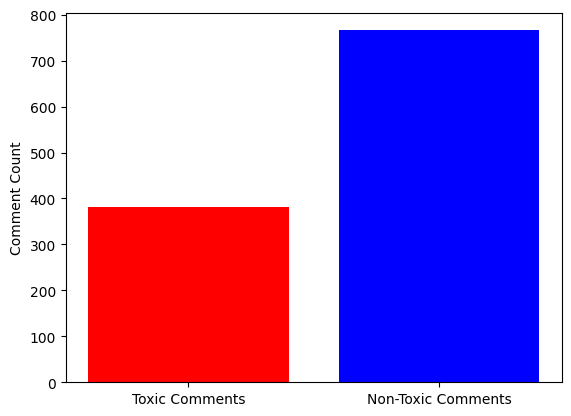

In [63]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['toxic'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Visualization of toxicity in test

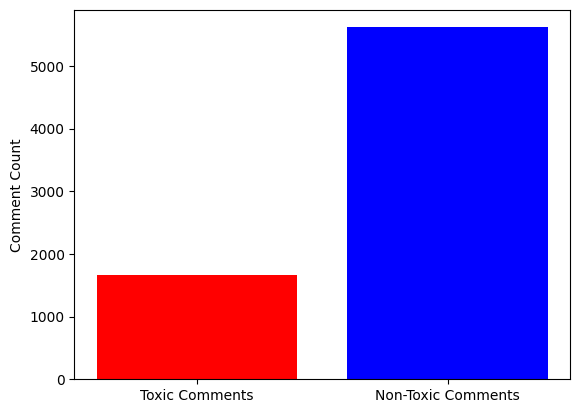

In [64]:
# Count toxic and non-toxic comments
toxic_count = toxicity_test_df['toxic'].sum()
non_toxic_count = len(toxicity_test_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Splitting and Labelling

In [39]:
# model_name = "roberta-base"

# toxicity_train_df.reset_index(drop=True, inplace=True)
# toxicity_test_df.reset_index(drop=True, inplace=True)

# X_train = toxicity_train_df[['comment_text']].reset_index(drop=True)
# X_train = X_train.dropna()

# # y_train = toxicity_train_df[['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']]
# y_train = toxicity_train_df[['toxic']].reset_index(drop=True)
# y_train = y_train.dropna()
# # toxicity_train_df.info()


# # toxicity_test_df.info()
# X_test = toxicity_test_df[['comment_text']].reset_index(drop=True)
# X_test = X_test.dropna()
# # # y_test = toxicity_test_df[['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']]
# y_test = toxicity_test_df[['toxic']].reset_index(drop=True)
# y_test = y_test.dropna()


# train_texts = X_train['comment_text'].tolist()
# train_labels = y_train
# test_texts = X_test['comment_text'].tolist()
# test_labels = y_test

# # See examples of texts & labels
# print("train_texts:")
# print(train_texts[:5])
# print("train_labels:")
# print(train_labels[:5])
# print("test_texts")
# print(test_texts[:5])
# print("test_labels:")
# print(test_labels[:5])

# train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

model_name = "roberta-base"

# Reset index to ensure consistency
toxicity_train_df.reset_index(drop=True, inplace=True)
toxicity_test_df.reset_index(drop=True, inplace=True)

# Select relevant columns from DataFrame and drop NaN values
train_data = toxicity_train_df[['comment_text', 'toxic']].dropna()
test_data = toxicity_test_df[['comment_text', 'toxic']].dropna()

# Extract features and labels
train_texts = train_data['comment_text'].tolist()
train_labels = train_data['toxic'].tolist()
test_texts = test_data['comment_text'].tolist()
test_labels = test_data['toxic'].tolist()

# Print examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
print("test_texts")
print(test_texts[:5])
print("test_labels:")
print(test_labels[:5])

# Split train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)


train_texts:
[' didn\'t he?"', ' white supremacists and all other left wing groups."', ' this man deserves the chair. He ruined the lives of these girls and THEN tries to have them killed? He needs to die... preferably suffering."', ' and casts his votes based on fact based common sense. Common sense has been missing in Eugene for a very long time! We sincerely need Clark. Its time for common sense to come back to our community!"', ' with a disabled plane or anything else outside of a lethal weapon. You\'re exaggerating because you don\'t like her or her paper."']
train_labels:
[0.0, 1.0, 1.0, 0.0, 1.0]
test_texts
['BS !', 'Hodad...does your user handle refer to your daughter??', "Many of them were wearing red Na'i Aupuni shirts.  Does that not show support for federal recognition?", '"Methinks your comment is indicative of your need to understand the Christian faith which does not require the subservience of woman as much as care and love for them by the man - ""as Christ loved the ch

# Dataset

In [40]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel


class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)
test_dataset = ToxicDataset(test_encodings, test_labels)

print("Train Dataset")
# Iterate over train_dataset and print some samples
for i in range(3):  # Print first 3 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Val Dataset")
# Iterate over val dataset and print some samples
for i in range(3):  # Print first 3 samples
    sample = val_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Test Dataset")
# Iterate over test dataset and print some samples
for i in range(3):  # Print first 3 samples
    sample = test_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

Train Dataset
Sample 1:
Encoding keys: ['<s>', 'Ġor', 'Ġwhat', 'Ġis', 'Ġexclusively', 'Ġliberal', 'Ġabout', 'Ġgood', 'Ġfood', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<

# Tokenizer + Encodings + Training

In [41]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.squeeze()

    # Apply sigmoid activation function to convert logits to probabilities
    preds = 1 / (1 + np.exp(-preds))

    # Round probabilities to get binary predictions
    binary_preds = np.round(preds)

    # Calculate accuracy
    accuracy = accuracy_score(labels, binary_preds)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, binary_preds, average='binary')

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    }

# Define the model with BCE loss
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

# Define the BCE loss function
loss_function = "bce_with_logits"  # Binary Cross-Entropy Loss

# Define the training arguments (GPU Version)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    warmup_steps=200,
    learning_rate=1e-6,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)


# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


model.save_pretrained('/results/fine_tuned_roberta_model')

# text = "Replace me by any text you'd like."
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)


ModuleNotFoundError: No module named 'datasets'

# Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

# Use the trained model for evaluation
eval_results = trainer.evaluate()

print("Evaluation results on the validation dataset:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

# Make predictions on the validation set
predictions = trainer.predict(val_dataset)

# Extract predicted labels and logits
predicted_labels = predictions.predictions.squeeze()
predicted_probs = 1 / (1 + np.exp(-predicted_labels))

# Step 1: Collect Uncalibrated Predictions
uncalibrated_predictions = predicted_labels

# Step 2: Fit Calibration Model (Isotonic Regression)
calibration_model = IsotonicRegression(out_of_bounds='clip')
calibrated_probabilities = calibration_model.fit_transform(uncalibrated_predictions, val_labels)

# Use a threshold of 0.50 to classify texts as toxic (1) or non-toxic (0)
threshold = 0.50
binary_predictions = (calibrated_probabilities >= threshold).astype(float)

# Compare predicted labels with actual labels
for i in range(len(val_texts)):
    print(f"Text: {val_texts[i]}")
    print(f"Predicted Probability: {calibrated_probabilities[i]}")
    print(f"Predicted Label: {binary_predictions[i]}")
    print(f"Actual Label: {val_labels[i]}")
    print()




# Convert predictions to probabilities and get class labels
predicted_probabilities = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)
predicted_labels = torch.argmax(predicted_probabilities, dim=1)

# Flatten the true labels
true_labels = np.array(val_labels)

# Calculate accuracy and print classification report
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")
print(classification_report(true_labels, predicted_labels))

# Count occurrences of each class in true labels
true_label_counts = np.bincount(true_labels.astype(int))

# Count occurrences of each class in predicted labels
predicted_label_counts = np.bincount(binary_predictions.astype(int))

# Print the counts
print("True Label Counts (Class 0 and 1):", true_label_counts)
print("Predicted Label Counts (Class 0 and 1):", predicted_label_counts)

# Separate predicted probabilities based on actual labels
toxic_probs = predicted_probs[np.where(np.array(val_labels) == 1)]
non_toxic_probs = predicted_probs[np.where(np.array(val_labels) == 0)]

# Plot histograms of predicted probabilities for both classes
plt.figure(figsize=(12, 8))
plt.hist(toxic_probs, bins=60, alpha=0.5, color='red', label='Toxic Comments')
plt.hist(non_toxic_probs, bins=60, alpha=0.5, color='blue', label='Non-Toxic Comments')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

# Predictions on Twitch Dataset

In [ ]:
import pandas as pd
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load the fine-tuned model for inference
tokenizer = RobertaTokenizer.from_pretrained('/content/results/checkpoint-3000/')
model = AutoModelForSequenceClassification.from_pretrained('/content/results/checkpoint-3000/')

twitch_df = pd.read_csv('twitch_toxicity.csv')
print(twitch_df.head(6))
print(twitch_df.info())

# Create a text classification pipeline
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

# Example function to apply the classifier to each row in the DataFrame
# count = 0

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

# Example function to apply the classifier to each row in the DataFrame
def predict_label(row):
    text_to_predict = row['comment_text']
    prediction = classifier(text_to_predict)
    return convert_label(prediction)

# Apply the prediction function to each row in the DataFrame
twitch_df['roberta_prediction'] = twitch_df.head(300).apply(predict_label, axis=1)
# twitch_df['roberta_prediction'] = twitch_df.apply(predict_label, axis=1)

# Display the DataFrame with predictions
print(twitch_df.head(300)[['comment_text', 'roberta_prediction', 'toxic']])

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df.head(300)['roberta_prediction'].value_counts()

# Print the counts
print("Count of 'no':", prediction_counts.get('no', 0))
print("Count of 'yes':", prediction_counts.get('yes', 0))  # Adjust the label if needed


# Native PyTorch (instead of HF Trainer)

In [42]:
from torch.utils.data import DataLoader
from transformers import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=1)
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=1e-4)

num_train_epochs = 1
for epoch in range(num_train_epochs):
  total_loss = 0.0
  for batch_idx, batch in enumerate(train_loader):
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

      loss = outputs[0]
      total_loss += loss.item()

      loss.backward()
      optim.step()

      if (batch_idx + 1) % 100 == 0:  # Print progress every 100 batches
          print(f"Epoch [{epoch + 1}/{num_train_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {total_loss / (batch_idx + 1):.4f}")

  print(f"Epoch [{epoch + 1}/{num_train_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")
#   for batch in train_loader:
#     optim.zero_grad()
#     input_ids = batch['input_ids'].to(device)
#     attention_mask = batch['attention_mask'].to(device)
#     labels = batch['labels'].to(device)

#     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

#     loss = outputs[0]
#     loss.backward()
#     optim.step()

model.eval()

model.save_pretrained('/usr/fine_tuned_roberta_model')

model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model')

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Assuming you have a validation DataLoader named val_loader
num_toxic_correct = 0
num_non_toxic_correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        predictions = torch.sigmoid(outputs.logits).squeeze()  # Assuming binary classification and using sigmoid activation

        predicted_labels = (predictions >= 0.5).float()

        num_toxic_correct += ((predicted_labels == 1) & (labels == 1)).sum().item()
        num_non_toxic_correct += ((predicted_labels == 0) & (labels == 0)).sum().item()
        total += labels.size(0)

accuracy_toxic = num_toxic_correct / total
accuracy_non_toxic = num_non_toxic_correct / total

print("Accuracy for toxic comments:", accuracy_toxic)
print("Accuracy for non-toxic comments:", accuracy_non_toxic)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/1], Average Loss: 0.2442
Accuracy for toxic comments: 0.3652173913043478
Accuracy for non-toxic comments: 0.0


# Default RoBERTa test as baseline

In [109]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-base')


# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

global count
count = 0

def predict_label(row):
    global count
    text_to_predict = row['comment_text']

    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    # if(count <100):
    #   print(probabilities)
    # Convert probabilities to binary labels
    binary_label = 1 if ((np.abs(probabilities[1] - probabilities[0]) <= 0.035) and (probabilities[1] > 0.5275) and (probabilities[0] < 0.494)) else 0
    count = count + 1
    # if (count % 100 == 0):
    #   print(count)
    if(count <10):
      print(text_to_predict)
      print(np.abs(probabilities[1] - probabilities[0]))
      print(binary_label)
    # if (binary_label == 1):
    #   print(text_to_predict)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('twitch_toxicity.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['roberta_prediction'] = twitch_df.head(2000).apply(predict_label, axis=1)

# Display the DataFrame with predictions
print(twitch_df[['comment_text', 'roberta_prediction']])

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df.head(2000)['roberta_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])  # Adjust the label if needed

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


11449
Confused why people are spamming things like Jupijej or Jupijej ? You can't see the emotes! Download the Jupijej browser extension to improve your chat experience! Jupijej
0.037448496
0
Nice thats my first time in Hasan Lifestream
0.03797251
0
THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO
0.03342387
0
Dont forget to check ur cocks before stream starts
0.034821928
0
THE HASANABI IS REAL LETSGO THE HASANABI IS REAL LETSGO
0.03496045
1
hey guys I'm finally here early, I love you
0.03578314
0
that was crazy timing i ramdomly clicked on him
0.036182553
0
i just clicked without notification bois had a feeling
0.036753297
0
HYPERPOGGER I was here on accident. Catching up on yesterday HYPERPOGGER
0.033694685
0
                                            comment_text  roberta_prediction
0      Confused why people are spamming things like J...                 0.0
1           Nice thats my first time in Hasan Lifestream                 0.0
2         THE ONE PIECE IS REAL LETSGO NEWS TODAY 

# Base Toxic Word Cloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


4     THE HASANABI IS REAL LETSGO THE HASANABI IS RE...
34    day 4823 of no pussy. My body abosorbs all the...
43    D/M/Y is the right date format Hasan is wrong ...
68    @errehpe, peepoPog wait are you actually LosPe...
70    Inediblelime subscribed at Tier 1. They've sub...
Name: comment_text, dtype: object


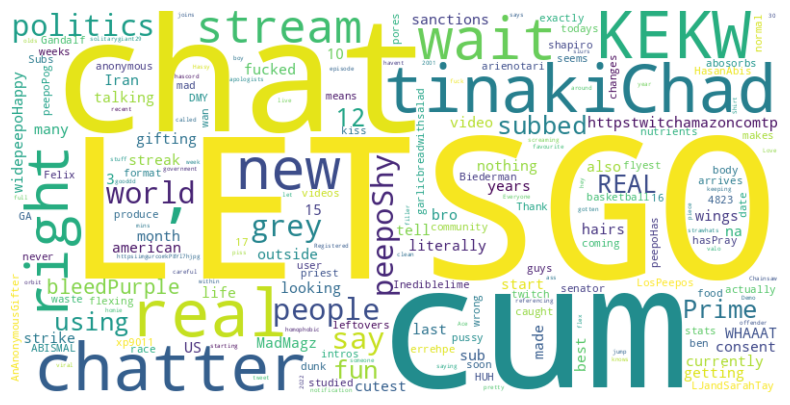

In [115]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['roberta_prediction'] == 1]['comment_text']
print(toxic_comments.head(5))

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really', 'Tier', 'tier', 'Tier 1',
                         '1', 'Theyve', 'theyve', 'going', 'subscribed', 'months']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Fine-Tuned Roberta on Twitch Dataset

In [90]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

global count
global sub_mention
sub_mention = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['comment_text']
    if ("Tier 1") in text_to_predict:
      sub_mention = True
    else:
      sub_mention = False
    # if(count <100):
    #   print(text_to_predict)
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    # if(count <100):
    #   print(probabilities)
    # Convert probabilities to binary labels
    binary_label = 1 if (np.abs(probabilities[0] > 0.592745) and not sub_mention) else 0
    count = count + 1
    # if (count % 100 == 0):
    #   print(count)
    if(count < 10):
      print(np.abs(probabilities[0]))
      print(text_to_predict)
      print(binary_label)
    # if (binary_label == 1):
    #   print(text_to_predict)
    # print(binary_label)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('twitch_toxicity.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['roberta_prediction'] = twitch_df.head(2000).apply(predict_label, axis=1)

# Display the DataFrame with predictions
print(twitch_df[['comment_text', 'roberta_prediction']])

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df.head(2000)['roberta_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])  # Adjust the label if needed

11449
0.59274256
Confused why people are spamming things like Jupijej or Jupijej ? You can't see the emotes! Download the Jupijej browser extension to improve your chat experience! Jupijej
0
0.59272313
Nice thats my first time in Hasan Lifestream
0
0.5926525
THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO
0
0.592745
Dont forget to check ur cocks before stream starts
1
0.59269565
THE HASANABI IS REAL LETSGO THE HASANABI IS REAL LETSGO
0
0.5927252
hey guys I'm finally here early, I love you
0
0.5927167
that was crazy timing i ramdomly clicked on him
0
0.5927287
i just clicked without notification bois had a feeling
0
0.5926785
HYPERPOGGER I was here on accident. Catching up on yesterday HYPERPOGGER
0
                                            comment_text  roberta_prediction
0      Confused why people are spamming things like J...                 0.0
1           Nice thats my first time in Hasan Lifestream                 0.0
2         THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO      

# Fine-Tuned Toxic Word Cloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


3     Dont forget to check ur cocks before stream st...
9     got here before the notif, yikes I have a problem
12    @rythympnxa naber agam @HasanAbi izlemeye mi g...
14    !leftovers abyssabyss2445 Most every thursday ...
20    y'all think he'll talk about the ticketmaster ...
Name: comment_text, dtype: object


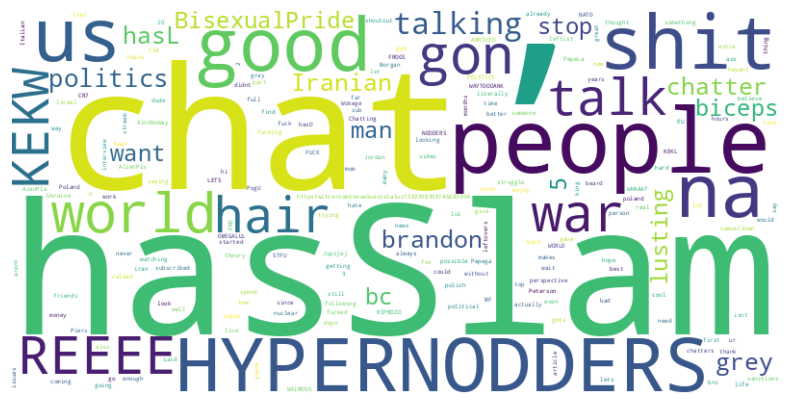

In [108]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['roberta_prediction'] == 1]['comment_text']
print(toxic_comments.head(5))

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
